In [1]:
# import warnings filter 
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


# Importing Dask packages
import dask.dataframe as dd
import dask.array as da

#import otheer needed python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

In [2]:
import os
import wget

# Extracting the dataset online

### To overwrite the previous datasets when re-running
if 'covid19_data.csv' in os.listdir("../data"):
    os.remove('/home/qwerty/Documents/Time Series Forecasting//data/covid19_data.csv')
    path = '/home/qwerty/Documents/Time Series Forecasting//data/covid19_data.csv'
    url =  "https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv"
    wget.download(url, path)
else:
    path = '/home/qwerty/Documents/Time Series Forecasting/data/covid19_data.csv'
    url =  "https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv"
    wget.download(url, path)
    
# Reading the dataset
data = dd.read_csv('../data/covid19_data.csv',
                   dtype={'Confirmed': 'float64','Deaths': 'float64', 'Recovered':'float64','Lat':'float64', 'long':'float64'})

### Preprocessing the datasets

In [3]:
data.head()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
1,2020-01-23,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
2,2020-01-24,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
3,2020-01-25,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
4,2020-01-26,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0


In [4]:
data.compute().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34977 entries, 0 to 34976
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            34977 non-null  object 
 1   Country/Region  34977 non-null  object 
 2   Province/State  10742 non-null  object 
 3   Lat             34977 non-null  float64
 4   Long            34977 non-null  float64
 5   Confirmed       34846 non-null  float64
 6   Recovered       33143 non-null  float64
 7   Deaths          34846 non-null  float64
dtypes: float64(5), object(3)
memory usage: 2.1+ MB


In [5]:
#Parsing the 'Date' feature to a date datatype 
data['Date'] = dd.to_datetime(data['Date'], infer_datetime_format=True) 

In [6]:
data.compute().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34977 entries, 0 to 34976
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            34977 non-null  datetime64[ns]
 1   Country/Region  34977 non-null  object        
 2   Province/State  10742 non-null  object        
 3   Lat             34977 non-null  float64       
 4   Long            34977 non-null  float64       
 5   Confirmed       34846 non-null  float64       
 6   Recovered       33143 non-null  float64       
 7   Deaths          34846 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 2.1+ MB


In [7]:
# Feature Creation
data['CurrentCase'] = data['Confirmed'] - data['Recovered'] - data['Deaths']

In [8]:
data.head()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths,CurrentCase
0,2020-01-22,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0,0.0
1,2020-01-23,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0,0.0
2,2020-01-24,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0,0.0
3,2020-01-25,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0,0.0
4,2020-01-26,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0,0.0


In [9]:
# Aggregating all cases in the world and grouping by date
date_df = data.groupby('Date')[['Confirmed' ,'Recovered', 'Deaths', 'CurrentCase']].sum()

In [10]:
date_df.columns

Index(['Confirmed', 'Recovered', 'Deaths', 'CurrentCase'], dtype='object')

In [11]:
date_df = date_df.reset_index()
date_df.head()

,Date,Confirmed,Recovered,Deaths,CurrentCase
0,2020-01-22,555.0,28.0,17.0,510.0
1,2020-01-23,654.0,30.0,18.0,606.0
2,2020-01-24,941.0,36.0,26.0,879.0
3,2020-01-25,1434.0,39.0,42.0,1353.0
4,2020-01-26,2118.0,52.0,56.0,2009.0


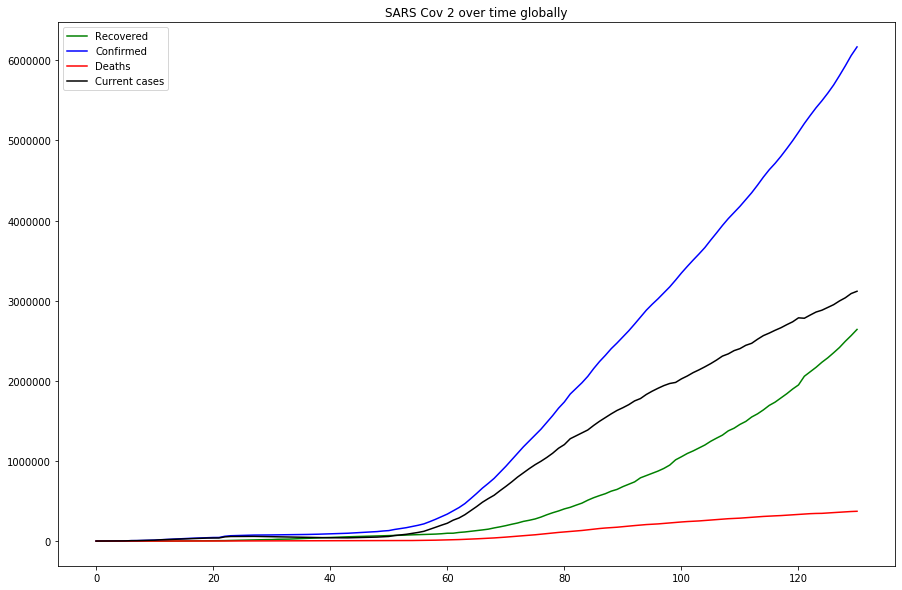

In [12]:
plt.figure(figsize=(15,10))
plt.plot(date_df["Recovered"].compute(),color='g',label='Recovered')
plt.plot(date_df["Confirmed"].compute(),color='b', label='Confirmed')
plt.plot(date_df["Deaths"].compute(),color='r',label='Deaths')
plt.plot(date_df['CurrentCase'].compute(),color='k', label='Current cases')
plt.title('SARS Cov 2 over time globally')
plt.legend();

In [13]:
# Model initialization
from fbprophet import Prophet
model = Prophet()

In [14]:
# Add seasonality
model.add_seasonality(name='Monthly', period=30.42, fourier_order=5)

In [15]:
### Splitting datasets operation
global_cases = date_df.reset_index()
confirmed_df = global_cases[['Date', 'Confirmed']]
recovered_df = global_cases[['Date', 'Recovered']]
deaths_df = global_cases[['Date', 'Deaths']]
current_df = global_cases[['Date', 'CurrentCase']]

In [16]:
# For Prophet to predict, its required for the names on the variables to be ds and y
def rename_func(dataframe):
    cols = dataframe.columns
    dataframe = dataframe.rename(columns= {cols[0]: 'ds', cols[1]:'y'})
    return dataframe

In [17]:
confirmed_df = rename_func(confirmed_df)
recovered_df = rename_func(recovered_df)
deaths_df = rename_func(deaths_df)
current_df = rename_func(current_df)

In [18]:
# Get overview of changes
confirmed_df.head()

,ds,y
0,2020-01-22,555.0
1,2020-01-23,654.0
2,2020-01-24,941.0
3,2020-01-25,1434.0
4,2020-01-26,2118.0


In [19]:
def train_test_split(dataframe, ratio):
    """
    Parameters:
    dataframe- Dataframe required to be split
    ratio: Percentage of training split in the scale of 0-100
    """
    divisor = round((ratio/100)*dataframe.compute().shape[0])
    #print(f'Division occurs at index {divisor}')
    train = dataframe.compute().iloc[:divisor]
    test = dataframe.compute().iloc[divisor:]
    return train, test, divisor

### Confirmed cases Prediction operations

In [20]:
confirmed_train, confirmed_test, divisor = train_test_split(confirmed_df, 70)

In [21]:
confirmed_train.shape, confirmed_test.shape

((92, 2), (39, 2))

In [22]:
# Fitting model
model.fit(confirmed_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
# Creating future dates
future_dates = model.make_future_dataframe(periods=39)

In [24]:
# Making predictions
predictions = model.predict(future_dates)

In [25]:
predictions.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Monthly,Monthly_lower,Monthly_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,-5608.827343,-4943.008587,2368.561400,-5608.827343,-5608.827343,8068.435955,8068.435955,8068.435955,4396.964960,4396.964960,4396.964960,-3671.470996,-3671.470996,-3671.470996,0.0,0.0,0.0,-1211.862384
1,2020-01-23,-5029.396839,-3874.349687,3436.290699,-5029.396839,-5029.396839,5205.685789,5205.685789,5205.685789,4766.131861,4766.131861,4766.131861,-439.553928,-439.553928,-439.553928,0.0,0.0,0.0,-263.264978
2,2020-01-24,-4449.966334,-1297.063537,6446.331702,-4449.966334,-4449.966334,3908.088751,3908.088751,3908.088751,6983.932466,6983.932466,6983.932466,3075.843715,3075.843715,3075.843715,0.0,0.0,0.0,2533.966132
3,2020-01-25,-3870.535829,-915.247900,6361.822659,-3870.535829,-3870.535829,3682.387561,3682.387561,3682.387561,6664.186865,6664.186865,6664.186865,2981.799304,2981.799304,2981.799304,0.0,0.0,0.0,2793.651037
4,2020-01-26,-432.041647,1479.389203,8850.984420,-432.041647,-432.041647,3346.603412,3346.603412,3346.603412,5686.017528,5686.017528,5686.017528,2339.414116,2339.414116,2339.414116,0.0,0.0,0.0,5253.975881


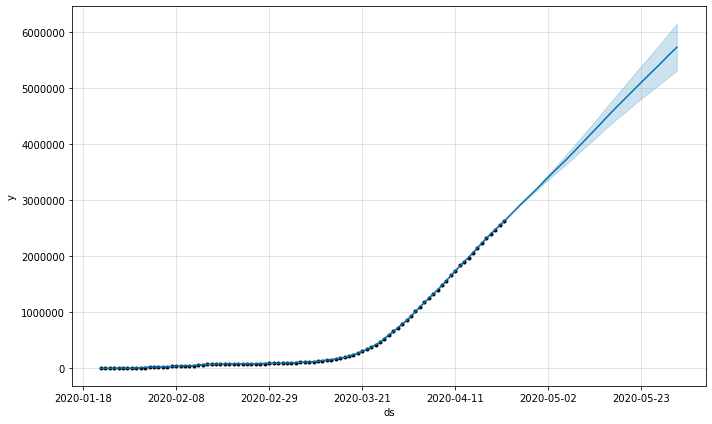

In [26]:
fig = model.plot(predictions);
fig;

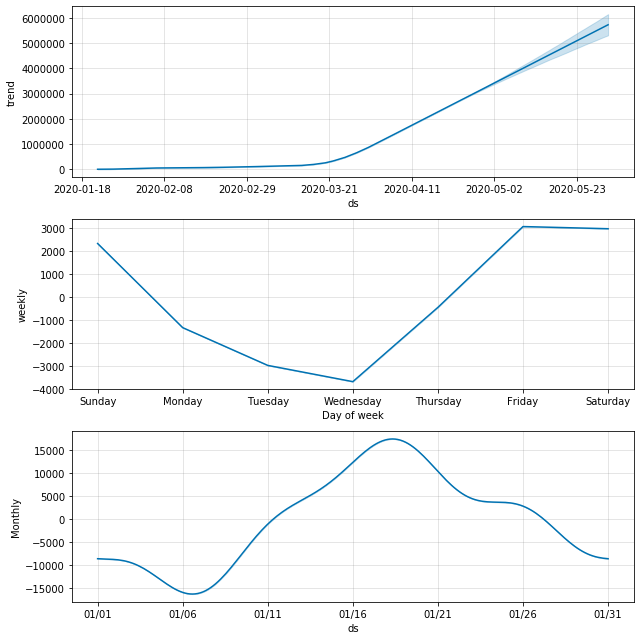

In [27]:
fig = model.plot_components(predictions);
fig;

In [28]:
def check_metrics(test, predictions):
    mse_score = np.sqrt(mean_squared_error(test['y'],predictions['yhat'].iloc[divisor:]))
    R2_score = r2_score(test['y'],predictions['yhat'].iloc[divisor:])
    print(f"MSE: {mse_score}")
    print(f"R-square Score: {R2_score}")

In [29]:
check_metrics(confirmed_test, predictions)

MSE: 160862.61032761785
R-square Score: 0.9746058923124146


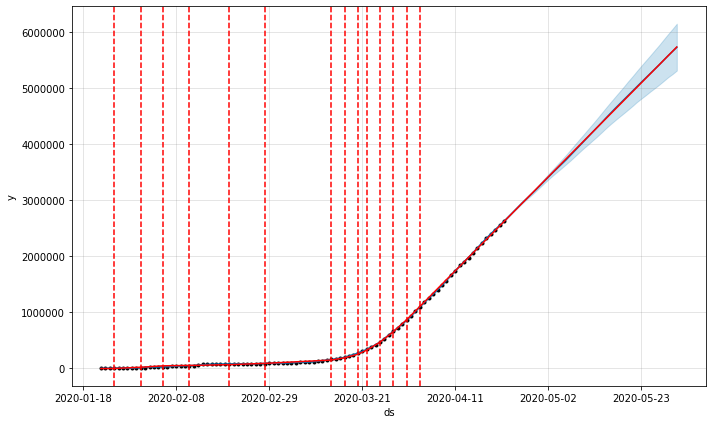

In [30]:
from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(predictions)
changes = add_changepoints_to_plot(fig.gca(), model, predictions)

In [31]:
data.compute().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34977 entries, 0 to 34976
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            34977 non-null  datetime64[ns]
 1   Country/Region  34977 non-null  object        
 2   Province/State  10742 non-null  object        
 3   Lat             34977 non-null  float64       
 4   Long            34977 non-null  float64       
 5   Confirmed       34846 non-null  float64       
 6   Recovered       33143 non-null  float64       
 7   Deaths          34846 non-null  float64       
 8   CurrentCase     33012 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 2.4+ MB


In [32]:
def determinate_beta_gamma_delta(data=None):
    '''
        this function compute transmission rate, recovered rate and fatalities rate over time
        params: data
        return: beta, gamma, delta
    '''
    
    beta = []
    gamma = []
    delta = []
    
    for t in range(len(data.Date.compute().values)):
        
        x = data.Confirmed.compute().iloc[t]
        y = data.Deaths.compute().iloc[t]
        z = data.Recovered.compute().iloc[t]
        w = data.CurrentCase.compute().iloc[t]
        
        if x == 0.0:
            beta.append(0)
            gamma.append(0)
            delta.append(0)
        else:
            beta_t = w/x
            gamma_t = z/x
            delta_t = y/x
            
            beta.append(beta_t)
            gamma.append(gamma_t)
            delta.append(delta_t)
            
    return np.array(beta), np.array(gamma), np.array(delta)        

In [33]:
transmission, recovery, fatality = determinate_beta_gamma_delta(data=global_cases)

In [34]:
parameter_dynamic = pd.DataFrame()
parameter_dynamic['beta'] = transmission
parameter_dynamic['gamma'] = recovery
parameter_dynamic['delta'] = fatality
parameter_dynamic['Date'] = global_cases.Date
parameter_dynamic = parameter_dynamic.set_index('Date')

In [35]:
parameter_dynamic.head()

,beta,gamma,delta
Date,,,
2020-01-22,0.918919,0.050450,0.030631
2020-01-23,0.926606,0.045872,0.027523
2020-01-24,0.934113,0.038257,0.027630
2020-01-25,0.943515,0.027197,0.029289
2020-01-26,0.948536,0.024551,0.026440


In [36]:
def find_R0(data=None):
    '''
        This function compute R0 over time
        params: data
        return: R0
    '''
    return data.beta.values/(data.gamma.values + data.delta.values)

In [37]:
#Compute R0
parameter_dynamic['R0'] = find_R0(data=parameter_dynamic)
print(parameter_dynamic['R0'].min())
parameter_dynamic.columns=['\u03B2', '\u03B3', '\u03B4','R0']
parameter_dynamic.columns

0.7019303822001705


Index(['β', 'γ', 'δ', 'R0'], dtype='object')

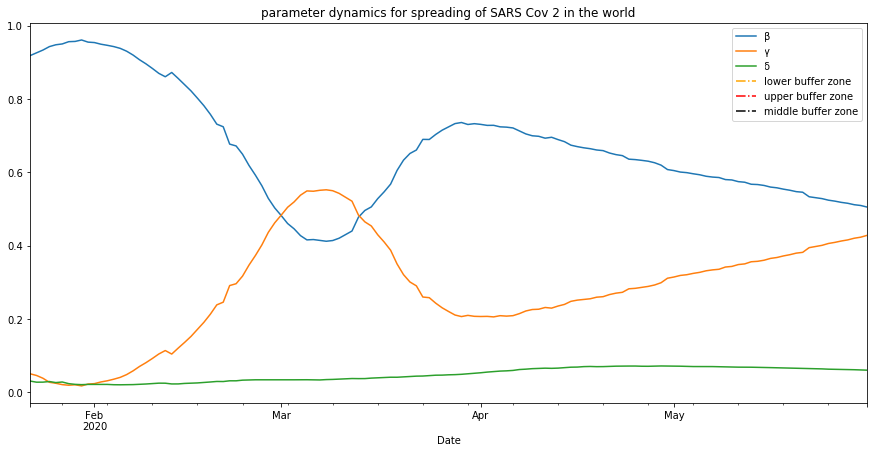

In [38]:
parameter_dynamic[['\u03B2', '\u03B3', '\u03B4']].plot(figsize=(15,7))
plt.hlines(0.35, 0, 140, linestyles='dashdot',color='orange',label='lower buffer zone')
plt.hlines(0.63, 0, 140, linestyles='dashdot',color='red', label='upper buffer zone')
plt.hlines(0.49, 0, 140, linestyles='dashdot', color='black',label='middle buffer zone')
plt.legend(loc='best')
plt.title('parameter dynamics for spreading of SARS Cov 2 in the world')
plt.savefig('paramater dynamics.png')

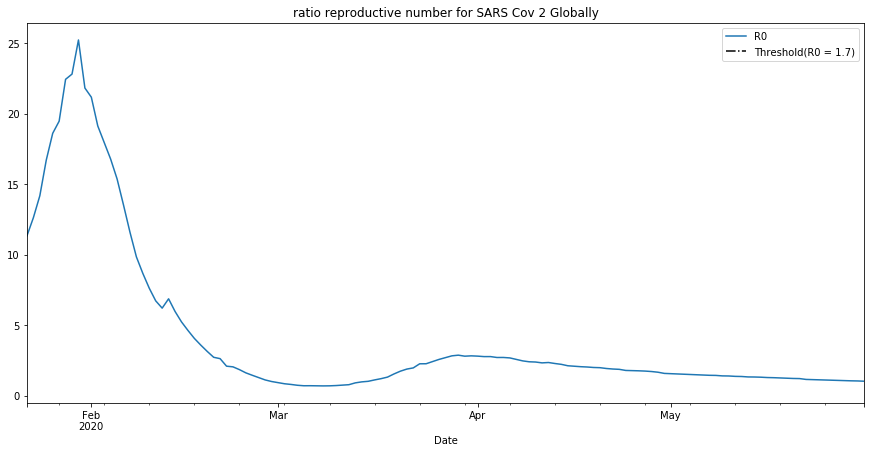

In [39]:
# Plot R0
parameter_dynamic['R0'].plot(figsize=(15,7))
plt.hlines(1.67, 10, 140, linestyles='dashdot', label='Threshold(R0 = 1.7)')
plt.legend(loc='best')
plt.title('ratio reproductive number for SARS Cov 2 Globally')
plt.savefig('reproductive rate.png')

In [40]:
def growth_rate(data=None):
    """
        This function compute a growth rate of one variable
        params: data
        return: growth rate x
    
    """
    x = []
    x.append(0)
    for i in range(data.compute().shape[0]-1):
        a = data.compute().iloc[i+1]-data.compute().iloc[i]
        b = a/data.compute().iloc[i]
        x.append(b)
        
    return np.array(x)

In [41]:
growth_rate_currentCase = pd.DataFrame(growth_rate(data=global_cases.CurrentCase), columns=['currentCase'])

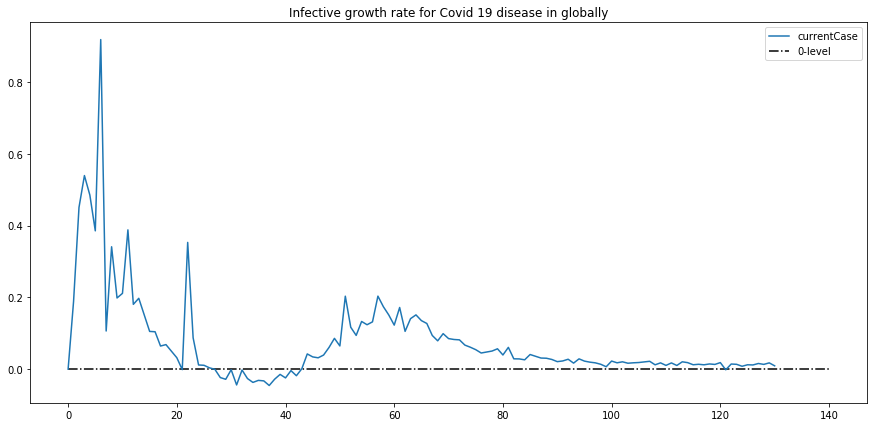

In [42]:
growth_rate_currentCase.plot(figsize=(15,7))
plt.hlines(0, 0, 140, linestyles='dashdot', label='0-level')
plt.legend(loc='best')
plt.title('Infective growth rate for Covid 19 disease in globally')
plt.savefig('Growthrate.png')